## Import Data Into Data Frame

In [1]:
import pandas as pd
train_df=pd.read_csv('final_dummies_training.csv',index_col=0)
validate_df=pd.read_csv('final_dummies_evaluation.csv', index_col=0)


In [2]:
train_text=train_df['text']
validate_text=validate_df['text']

In [3]:
train_otherfeature=train_df.drop(['text', 'review_id', 'normalized_votes','Label'],axis=1)
validate_otherfeature=validate_df.drop(['text', 'review_id', 'normalized_votes','Label'],axis=1)

# Binary Representation:

To create a matrix that uses each word as a feature and keeps track of whether or not a word appears in a review text

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
binary_vectorizer=CountVectorizer(binary=True)
binary_vectorizer.fit(train_text)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [5]:
train_binary = binary_vectorizer.transform(train_text)
validate_binary = binary_vectorizer.transform(validate_text)

### Merge with other features
#### Training Set

In [6]:
import scipy as sp
train_otherfeature=sp.sparse.csr_matrix(train_otherfeature)
train_binary=sp.sparse.hstack([train_binary,train_otherfeature])

#### Validation Set

In [7]:
validate_otherfeature=sp.sparse.csr_matrix(validate_otherfeature)
validate_binary=sp.sparse.hstack([validate_binary,validate_otherfeature])

### Basic Decision Tree with min_samples_leaf=1, max_depth=3

In [8]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 1, max_depth = 3)
clf = clf.fit(train_binary,train_df['Label'])

In [9]:
from sklearn.metrics import roc_auc_score
print("Area under the ROC curve on the test data = %.3f" % roc_auc_score(clf.predict(validate_binary),validate_df['Label']))

Area under the ROC curve on the test data = 0.659


In [10]:
clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf=1, max_depth=3)
clf = clf.fit(train_binary,train_df['Label'])

In [11]:
from sklearn.metrics import roc_auc_score
print("Area under the ROC curve on the test data = %.3f" % roc_auc_score(clf.predict(validate_binary),validate_df['Label']))

Area under the ROC curve on the test data = 0.658


### Find the best parameters for decision tree classifier 

In [12]:
#depth of 15 was tested- it requires a really long time to run; Hence, the depth is limited to upto 10
max_depth =[7,8,9,10]
min_samples_leaf_values = [100,500,1000,2000]

In [13]:
#Run all of the options
run=1
if (run == 1):
    #Initialize dictionary of results
    res = dict()
    for d in max_depth:
        res[d] = list()

    #Now train and get results for each option
    for d in max_depth:
        for l in min_samples_leaf_values:
            model=DecisionTreeClassifier(criterion='entropy',min_samples_leaf=l,max_depth=d)
            model=model.fit(train_binary,train_df['Label'])
            res[d].append(roc_auc_score(model.predict(validate_binary),validate_df['Label']))



##### Plot Holdout AUC by Hyperparameters

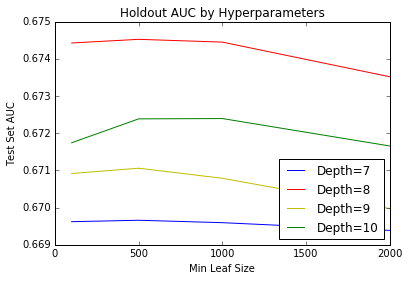

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot            
fig = plt.figure()
ax=fig.add_subplot(111)
plt.plot(min_samples_leaf_values,res[max_depth[0]], 'b-', label = 'Depth={}'.format(max_depth[0]))
plt.plot(min_samples_leaf_values,res[max_depth[1]], 'r-', label = 'Depth={}'.format(max_depth[1]))
plt.plot(min_samples_leaf_values,res[max_depth[2]], 'y-', label = 'Depth={}'.format(max_depth[2]))
plt.plot(min_samples_leaf_values,res[max_depth[3]], 'g-', label = 'Depth={}'.format(max_depth[3]))

plt.legend(loc = 4)
ax.set_xlabel('Min Leaf Size')
ax.set_ylabel('Test Set AUC')
plt.title('Holdout AUC by Hyperparameters')


In [15]:
max_depth_value=max_depth[0]
min_sampls_leaf=min_samples_leaf_values[0]
maxAUC=res[max_depth_value][min_samples_leaf_values.index(min_sampls_leaf)]
for d in max_depth:
    for l in range(0,4):
        if res[d][l]>maxAUC:
            maxAUC=res[d][l]
            min_sampls_leaf=min_samples_leaf_values[l]
            max_depth_value=d
print("Best AUC is= %.3f" % maxAUC)
print("Configuration is min_samples_leaf at",min_sampls_leaf,"depth at",max_depth_value)


Best AUC is= 0.675
Configuration is min_samples_leaf at 500 depth at 8


# Count Representation:

In [16]:
count_vectorizer=CountVectorizer()
count_vectorizer.fit(train_text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [17]:
train_count = count_vectorizer.transform(train_text)
validate_count = count_vectorizer.transform(validate_text)

### Merge with other features

In [18]:
train_count=sp.sparse.hstack([train_count,train_otherfeature])
validate_count=sp.sparse.hstack([validate_count,validate_otherfeature])

### Basic Decision Tree with min_samples_leaf=1, max_depth=3

In [19]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 1, max_depth = 3)
clf = clf.fit(train_count,train_df['Label'])

In [20]:
print("Area under the ROC curve on the test data = %.3f" % roc_auc_score(clf.predict(validate_count),validate_df['Label']))

Area under the ROC curve on the test data = 0.658


In [21]:
clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf = 1, max_depth = 3)
clf = clf.fit(train_count,train_df['Label'])

In [22]:
print("Area under the ROC curve on the test data = %.3f" % roc_auc_score(clf.predict(validate_count),validate_df['Label']))

Area under the ROC curve on the test data = 0.658


### Find the best parameters for decision tree classifier 

In [23]:
#Run all of the options
run=1
if (run == 1):
    #Initialize dictionary of results
    res = dict()
    for d in max_depth:
        res[d] = list()

    #Now train and get results for each option
    for d in max_depth:
        for l in min_samples_leaf_values:
            model=DecisionTreeClassifier(criterion='entropy',min_samples_leaf=l,max_depth=d)
            model=model.fit(train_count,train_df['Label'])
            res[d].append(roc_auc_score(model.predict(validate_count),validate_df['Label']))


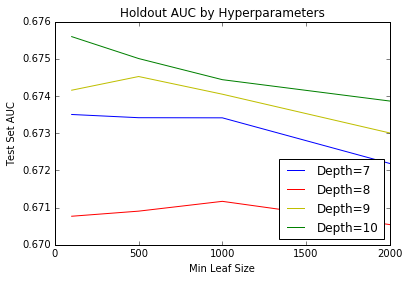

In [24]:
#plot            
fig = plt.figure()
ax=fig.add_subplot(111)
plt.plot(min_samples_leaf_values,res[max_depth[0]], 'b-', label = 'Depth={}'.format(max_depth[0]))
plt.plot(min_samples_leaf_values,res[max_depth[1]], 'r-', label = 'Depth={}'.format(max_depth[1]))
plt.plot(min_samples_leaf_values,res[max_depth[2]], 'y-', label = 'Depth={}'.format(max_depth[2]))
plt.plot(min_samples_leaf_values,res[max_depth[3]], 'g-', label = 'Depth={}'.format(max_depth[3]))
plt.legend(loc = 4)
ax.set_xlabel('Min Leaf Size')
ax.set_ylabel('Test Set AUC')
plt.title('Holdout AUC by Hyperparameters')


In [26]:
max_depth_value=max_depth[0]
min_sampls_leaf=min_samples_leaf_values[0]
maxAUC=res[max_depth_value][min_samples_leaf_values.index(min_sampls_leaf)]
for d in max_depth:
    for l in range(0,4):
        if res[d][l]>maxAUC:
            maxAUC=res[d][l]
            min_sampls_leaf=min_samples_leaf_values[l]
            max_depth_value=d
print("Best AUC is= %.3f" % maxAUC)
print("Configuration is min_samples_leaf at",min_sampls_leaf,"depth at",max_depth_value)

Best AUC is= 0.676
Configuration is min_samples_leaf at 100 depth at 10


# TF-idf Representation:

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
tfidf_vectorizer=TfidfVectorizer()
tfidf_vectorizer.fit(train_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [29]:
train_tfidf = tfidf_vectorizer.transform(train_text)
validate_tfidf = tfidf_vectorizer.transform(validate_text)

### Merge with other features


In [30]:
train_tfidf=sp.sparse.hstack([train_tfidf,train_otherfeature])
validate_tfidf=sp.sparse.hstack([validate_tfidf,validate_otherfeature])

### Basic Decision Tree with min_samples_leaf=1, max_depth=3

In [31]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 1, max_depth = 3)
clf = clf.fit(train_tfidf,train_df['Label'])

In [32]:
print("Area under the ROC curve on the test data = %.3f" % roc_auc_score(clf.predict(validate_tfidf),validate_df['Label']))

Area under the ROC curve on the test data = 0.659


In [33]:
clf = DecisionTreeClassifier(criterion='gini', min_samples_leaf = 1, max_depth = 3)
clf = clf.fit(train_tfidf,train_df['Label'])

In [34]:
print("Area under the ROC curve on the test data = %.3f" % roc_auc_score(clf.predict(validate_tfidf),validate_df['Label']))

Area under the ROC curve on the test data = 0.658


### Find the best parameters for decision tree classifier 

In [36]:
#Run all of the options
run=1
if (run == 1):
    #Initialize dictionary of results
    res = dict()
    for d in max_depth:
        res[d] = list()

    #Now train and get results for each option
    for d in max_depth:
        for l in min_samples_leaf_values:
            model=DecisionTreeClassifier(criterion='entropy',min_samples_leaf=l,max_depth=d)
            model=model.fit(train_tfidf,train_df['Label'])
            res[d].append(roc_auc_score(model.predict(validate_tfidf),validate_df['Label']))


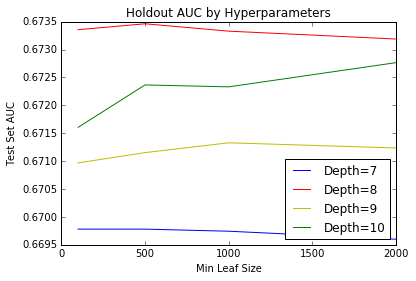

In [37]:
#plot            
fig = plt.figure()
ax=fig.add_subplot(111)
plt.plot(min_samples_leaf_values,res[max_depth[0]], 'b-', label = 'Depth={}'.format(max_depth[0]))
plt.plot(min_samples_leaf_values,res[max_depth[1]], 'r-', label = 'Depth={}'.format(max_depth[1]))
plt.plot(min_samples_leaf_values,res[max_depth[2]], 'y-', label = 'Depth={}'.format(max_depth[2]))
plt.plot(min_samples_leaf_values,res[max_depth[3]], 'g-', label = 'Depth={}'.format(max_depth[3]))
plt.legend(loc = 4)
ax.set_xlabel('Min Leaf Size')
ax.set_ylabel('Test Set AUC')
plt.title('Holdout AUC by Hyperparameters')


In [38]:
max_depth_value=max_depth[0]
min_sampls_leaf=min_samples_leaf_values[0]
maxAUC=res[max_depth_value][min_samples_leaf_values.index(min_sampls_leaf)]
for d in max_depth:
    for l in range(0,4):
        if res[d][l]>maxAUC:
            maxAUC=res[d][l]
            min_sampls_leaf=min_samples_leaf_values[l]
            max_depth_value=d
print("Best AUC is= %.3f" % maxAUC)
print("Configuration is min_samples_leaf at",min_sampls_leaf,"depth at",max_depth_value)

Best AUC is= 0.673
Configuration is min_samples_leaf at 500 depth at 8


## Model Selection Results - Among Decision Tree Model and Test Mining Technique


Based on the AUC, the best model parameter and test mining method combination is decision tree with minimal leaf number of 100, depth of 10 for text transformed from count representation 

### Fit the Model with Both Training and Validation Data Sets


In [41]:
training=train_df.append(validate_df)

In [43]:
test_df=pd.read_csv('final_dummies_test.csv',index_col=0)

In [44]:
train_text=training['text']
test_text=test_df['text']

In [60]:
train_otherfeature=training.drop(['text', 'review_id', 'normalized_votes','Label','Unnamed: 0.1'],axis=1)
test_otherfeature=test_df.drop(['text', 'review_id', 'normalized_votes','Label'],axis=1)

In [46]:
count_vectorizer=CountVectorizer()
count_vectorizer.fit(train_text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [61]:
train_count = count_vectorizer.transform(train_text)
test_count = count_vectorizer.transform(test_text)

In [63]:
train_count=sp.sparse.hstack([train_count,train_otherfeature])
test_count=sp.sparse.hstack([test_count,test_otherfeature])

In [64]:
clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 100, max_depth = 10)
clf = clf.fit(train_count,training['Label'])

#### Evaluate the Fitted Model with Test Data Set

In [65]:
print("Area under the ROC curve on the test data = %.3f" % roc_auc_score(clf.predict(test_count),test_df['Label']))

Area under the ROC curve on the test data = 0.675
